# Remote Runner
This lesson will demonstrate use of the `RemoteRunner` class which allows you to run pyhton workflows on a remote machine. 

## Remote Runner Infrastructure
First we construct the infastructure needed for remote runs. What you need to do is to instantiate a class named `RemoteRunner`. 
Such class needs a script template. This will generate the jobscript that you want to submit on the remote machine.
Such a script template can be provided as a string or as a function which returns a string. In this second case the argument of this function can be
used to specify the template script to a given run.
Then, this class requires a python function, its arguments, and the url of the remote machine in which we would like to calculation to be done.

We start this example with a script provided as a string. We will then specify the situation to a set of calculations and a set of scripts with dependencies.

In [1]:
import BigDFT.RemoteRunners as R

In [2]:
local_scr="""#!/bin/bash
export I_MPI_FABRICS=ofi
# BigDFT Parallelism
export BIGDFT_MPIRUN="mpirun -np NMPIVAR"
export OMP_NUM_THREADS=NOMPVAR

# General Environment
source BIGDFT_PREFIX/bin/bigdftvars.sh

# Actual Run goes after this line
"""

There are keywords in this script that will be substituted with arguments. This will let you configure things on a per calculation run, such as the number of nodes used, number of openmp threads, etc. This can also be implemented more explicitly via a function with arguments which returns the substitutes script as a string. Now we are ready to instantiate an object of this class.

## Calculation Examples
Now let's try an example calculation. The remote runner can be used to run any snippet of python code. Let's try something very simple.

In [3]:
def hello_world(argument):
    from time import sleep
    sleep(20)
    return "hello " + argument

In [4]:
remote_code = R.RemoteRunner(hello_world,arguments=dict(argument='BigDFT'),
                             remote_dir='/tmp', script=local_scr,
                             NMPIVAR=1,NOMPVAR=1, BIGDFT_PREFIX='/opt/bigdft/install',
                             skip=False)

The run command is used to submit a job. 

As for the arguments to the run command, we pass: a unique name for the calculation, a directory we want to run in, and we can also pass a dictionary of arguments that are passed to our custom `make_script` function. The `name` will be important for checking if the calculation has been run. The optional `run_dir` helps prevent name clashes. Note that this directory will also be created locally for storing some temporary files.

In [5]:
remote_code.run(asynchronous=True)

rsync -auv /tmp/remotefunction-run.sh /tmp/remotefunction-function-files.tar.gz /tmp/remotefunction-function-run.py /tmp
cd /tmp && bash remotefunction-run.sh &


What we need to do next is just wait for the calculation to complete. The runner has the functions we need in order to check if a calculation is done.

In [6]:
remote_code.is_finished()

True

In [7]:
from time import sleep
while not remote_code.is_finished("hello_bigdft", "examples"): sleep(5.0)
return_str = remote_code.fetch_result()

In [8]:
print(return_str)

hello BigDFT


The same script, can be executed on a remote machine to which we have ssh access to.
We can add the `url` command at the instantiation, or re-call the run method of the same instance.

In [9]:
remote_code.files_sent(False)
remote_code.run(url='irene')

rsync -auv /tmp/remotefunction-run.sh /tmp/remotefunction-function-files.tar.gz /tmp/remotefunction-function-run.py irene:/tmp
ssh irene "cd /tmp && bash remotefunction-run.sh"


In [10]:
remote_code.fetch_result()

rsync -auv irene:/tmp/remotefunction-function-result.json /tmp/


'hello BigDFT'

## BigDFT Calculation Dataset
The above example show a simple function.
In this section, we will try running a set of BigDFT calculation remotely. We can set up the system and input files locally.
We can then employ this technology to submit a set of jobs to a remote machine 
This class should take as an argument the name of the remote directory you wish to run calculations in and whether you want to force the evaluation through the `force` option. It also takes an argument `database` which is the name of a local file you will use to store the status of the remote database.

In [11]:
import BigDFT.RemoteRunners as R
from BigDFT.Inputfiles import Inputfile
from copy import deepcopy
input_files = {}

inp = Inputfile()
inp.set_xc("PBE")

for cutoff in ["0.4", "0.37", "0.35", "0.3"]:
    input_files[cutoff] = deepcopy(inp)
    input_files[cutoff].set_hgrid(float(cutoff))

Now we will run write a function which invokes the system calculator and returns the logfile.

In [22]:
def run_calculation(basename, inp):
    from BigDFT.IO import XYZReader
    from BigDFT.Systems import System
    from BigDFT.Fragments import Fragment

    sys = System()
    with XYZReader("H2O") as ifile:
        sys["WAT:0"] = Fragment(xyzfile=ifile)

    from BigDFT.Calculators import SystemCalculator
    code = SystemCalculator()
    log = code.run(posinp=sys.get_posinp(), input=inp, name=basename) 
    return log

Launch all of the calculations.

In [33]:
remote_dataset = R.RemoteDataset(function=run_calculation, run_dir="examples",remote_dir='/tmp', protocol='Dill',
                                 script=local_scr, NMPIVAR=1,NOMPVAR=1, BIGDFT_PREFIX='/opt/bigdft/install')

Here we substitute the arguments of the function. We inherit `name` and `skip` from the dataset creation,
therefore we only have to specify the `inp` argument

In [34]:
for cutoff, inp in input_files.items():
    remote_dataset.append_run(id={'h':cutoff},arguments=dict(name=cutoff,inp=inp))

We now have the concept of database which keeps track of the runs which have been submitted:

In [35]:
remote_dataset.calculators

[{'calc': <BigDFT.RemoteRunners.RemoteRunner at 0x7ff13f66b510>, 'runs': [0]},
 {'calc': <BigDFT.RemoteRunners.RemoteRunner at 0x7ff13f676590>, 'runs': [1]},
 {'calc': <BigDFT.RemoteRunners.RemoteRunner at 0x7ff13f5c1d50>, 'runs': [2]},
 {'calc': <BigDFT.RemoteRunners.RemoteRunner at 0x7ff13f58d090>, 'runs': [3]}]

The calculation can now be submitted

In [36]:
remote_dataset.run(force=True,run_dir='/tmp')

rsync -auv examples/h=0.4-run.sh examples/0.4-serialize.dill examples/0.4-run.py examples/h=0.37-run.sh examples/0.37-serialize.dill examples/0.37-run.py examples/h=0.35-run.sh examples/0.35-serialize.dill examples/0.35-run.py examples/h=0.3-run.sh examples/0.3-serialize.dill examples/0.3-run.py /tmp
rsync -auv /tmp/0.4-result.dill examples/
rsync -auv /tmp/0.37-result.dill examples/
rsync -auv /tmp/0.35-result.dill examples/
rsync -auv /tmp/0.3-result.dill examples/


{0: <BigDFT.Logfiles.Logfile at 0x7ff14044f0d0>,
 1: <BigDFT.Logfiles.Logfile at 0x7ff1404249d0>,
 2: <BigDFT.Logfiles.Logfile at 0x7ff1525ce7d0>,
 3: <BigDFT.Logfiles.Logfile at 0x7ff1403b6850>}

In [37]:
remote_dataset.database

['h=0.4', 'h=0.37', 'h=0.35', 'h=0.3']

In [38]:
remote_dataset.run()

/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/RemoteRunners.py:778: UserWarning: ('h=0.4', 'examples') already submitted
  UserWarning)
/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/RemoteRunners.py:778: UserWarning: ('h=0.37', 'examples') already submitted
  UserWarning)
/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/RemoteRunners.py:778: UserWarning: ('h=0.35', 'examples') already submitted
  UserWarning)
/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/RemoteRunners.py:778: UserWarning: ('h=0.3', 'examples') already submitted
  UserWarning)


{0: <BigDFT.Logfiles.Logfile at 0x7ff14044f0d0>,
 1: <BigDFT.Logfiles.Logfile at 0x7ff1404249d0>,
 2: <BigDFT.Logfiles.Logfile at 0x7ff1525ce7d0>,
 3: <BigDFT.Logfiles.Logfile at 0x7ff1403b6850>}

In [39]:
remote_dataset.clean_database()

We are now running many calculations in the background, and want to wait for them all to complete before proceeding. One way this can be accomplished is as follows:

In [40]:
remote_dataset.run(url='irene',force=True,skip=False)

rsync -auv examples/h=0.4-run.sh examples/0.4-serialize.dill examples/0.4-run.py examples/h=0.37-run.sh examples/0.37-serialize.dill examples/0.37-run.py examples/h=0.35-run.sh examples/0.35-serialize.dill examples/0.35-run.py examples/h=0.3-run.sh examples/0.3-serialize.dill examples/0.3-run.py irene:/tmp
rsync -auv irene:/tmp/0.4-result.dill examples/
rsync -auv irene:/tmp/0.37-result.dill examples/
rsync -auv irene:/tmp/0.35-result.dill examples/
rsync -auv irene:/tmp/0.3-result.dill examples/


{0: <BigDFT.Logfiles.Logfile at 0x7ff13f5a3150>,
 1: <BigDFT.Logfiles.Logfile at 0x7ff13f4dae90>,
 2: <BigDFT.Logfiles.Logfile at 0x7ff13f5a7050>,
 3: <BigDFT.Logfiles.Logfile at 0x7ff13f487110>}

In [41]:
logfiles = remote_code.block_all(input_files, "examples")

AttributeError: 'RemoteRunner' object has no attribute 'block_all'

In [26]:
logfiles = {c:v for c, v in zip(input_files,remote_dataset.fetch_results())}

In [20]:
print(remote_code.database)

['0.4', '0.37', '0.35', '0.3']


The implementation of `block_all` is rather simple and is something you might want to customize for your workflows.

In [21]:
from inspect import getsource
print(getsource(remote_code.block_all))

    def block_all(self, names, run_dir="."):
        """
        Block until all of the calculations in a list are completed.

        Args:
            names (list): a list of calculation names.
            run_dir (str): the directory the calculations were run in.

        Returns:
            A dictionary mapping names to results.
        """
        from time import sleep
        results = {}
        while any([x not in results for x in names]):
            for n in names:
                if n in results:
                    continue
                if self.is_finished(n, run_dir):
                    results[n] = self.get_results(n, run_dir)
            sleep(5.0)

        return results



Let's test that we received the completed output.

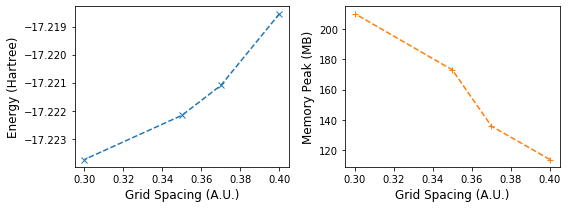

In [27]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot([float(x) for x in logfiles], 
            [x.energy for x in logfiles.values()],
            color='tab:blue', linestyle='--', marker='x')
axs[1].plot([float(x) for x in logfiles], 
            [x.memory_peak for x in logfiles.values()],
            color='tab:orange', linestyle='--', marker='+')
axs[0].set_xlabel("Grid Spacing (A.U.)", fontsize=12)
axs[1].set_xlabel("Grid Spacing (A.U.)", fontsize=12)
axs[0].set_ylabel("Energy (Hartree)", fontsize=12)
axs[1].set_ylabel("Memory Peak (MB)", fontsize=12)
fig.tight_layout()

# How this is implemented
The basic objects which are beind this implementation are the `RemoteFunction` and the `ExecutionScript` classes.
The first is responsible of the execution of a basic python function in a remote filesystem (which can also be a different directory on the local machine).
Let us made an exemple with a basic python function:

In [28]:
def do_we_have_bigdft_in_the_path():
    """This function checks if the BigDFT module is available in the path."""
    import importlib
    spec = importlib.util.find_spec("BigDFT")
    found = spec is not None
    return found

If this function returns `True` then we know that the `import BigDFT` command would work.

In [29]:
do_we_have_bigdft_in_the_path()

True

Let us now instantiate the `RemoteFunction` object. We need a local and a remote directory to do so.

In [30]:
from futile.Utils import ensure_dir
local_dir = 'example'
remote_dir = 'remote_example'
ensure_dir(local_dir)
ensure_dir(remote_dir)
from BigDFT import RemoteRunners as R

In [31]:
remote_test = R.RemoteJSONFunction('python','test_function',do_we_have_bigdft_in_the_path)

Such instatiation would enable to send this function to be executed in a given filesystem. Let us send this into a different directory (for this initial example, in the same filesystem)

In [32]:
remote_test.send_to(dest=remote_dir, src=local_dir)

rsync -auv example/test_function-run.py remote_example/test_function-run.py


Optionally (and more frequently) the remote directory should be on a machine to which we can access. This can be specified by putting the hostname to which we have access. A protocol that is different from rsync may also be employed. For this class, the user is responsible for the creation of the directory, which should exist.
Then, the function can be invoked. The way in which this is invoked is the responsibility of the `RemoteFunction` user.
The simplest example is to employ the `call` method, which creates the command to be invoked.

In [33]:
remote_test.call()

'cd remote_example && python test_function-run.py'

In [34]:
from os import system
system(remote_test.call())

0

We can then verify if the calculation has been finished:

In [35]:
remote_test.is_finished()

True

And eventually retrieve the result of the function.

In [36]:
remote_test.fetch_result()

rsync -auv remote_example/test_function-result.json example/


True

# The RemoteScript class
A class which iherits from the same object is the `RemoteScript`. This is based on a script.
This time, instead of providing the result as a python object, the `RemoteScript` instantiation should declare the name of
the file which would contain the result. It is user's responsibility to ensure that the filename does not clash with others.

In [37]:
script_template = """#!/bin/bash
export I_MPI_FABRICS=ofi
# BigDFT Parallelism
export BIGDFT_MPIRUN="mpirun -np NMPIVAR"
export OMP_NUM_THREADS=NOMPVAR

# General Environment
source BIGDFT_PREFIX/bin/bigdftvars.sh

echo The BIGDFT_ROOT environment variable is: "$BIGDFT_ROOT" > result_file
"""

In [38]:
remote_script=R.RemoteScript('bash','test_environment',script_template,'result_file',BIGDFT_PREFIX='/opt/bigdft/install/')

In [39]:
remote_script.send_to(dest='example')

rsync -auv /tmp/test_environment-run.sh example/test_environment-run.sh


In [40]:
from os import system
system(remote_script.call())

0

In [41]:
remote_script.fetch_result()

rsync -auv example/result_file /tmp//


['The BIGDFT_ROOT environment variable is: /opt/bigdft/install/bin\n']

For a (little) calculation that can be performed on the frontend of a given machine (like for instance a fast processin of logfiles), this function can be employed as is.
As per specification, we first have to ensure that the remote directory exists.

In [42]:
system('ssh irene "mkdir -p testdir"')

0

In [43]:
remote_script.send_to(dest='testdir',url='irene')
command = remote_script.call()
print (command)
system(command)

rsync -auv /tmp/test_environment-run.sh irene:testdir/test_environment-run.sh
ssh irene "cd testdir && bash test_environment-run.sh"


0

In [44]:
remote_script.fetch_result()

rsync -auv irene:testdir/result_file /tmp//


['The BIGDFT_ROOT environment variable is: \n']

From this last execution, we see that `BigDFT` is not installed in the same directory.

## The writability of a remote directory.
A useful example to show how this work is a remote test to ensure the writability of a remote directory.
Let us define a custom function and execute it remotely.
The pythonic example is inspired from [this](https://stackoverflow.com/questions/2113427/determining-whether-a-directory-is-writeable]) discussion.

In [45]:
script_writable = 'if [ -w "remotedir" ]; then echo "WRITABLE" > result; else echo "NOT WRITABLE" > result; fi'
def isWritable(path):
    import tempfile
    import errno
    try:
        testfile = tempfile.TemporaryFile(dir = path)
        testfile.close()
    except (OSError, IOError) as e:
        if e.errno == errno.EACCES or e.errno == errno.EEXIST:  # 13, 17
            return False
    return True

In [46]:
def test_writability(remote_dir, url):
    from time import sleep    
    test_writability = R.RemoteScript('bash','write_test',script_writable, 'result',remotedir=remote_dir)
    test_writability.send_to(url=url)
    command = test_writability.call()
    print(command)
    system(command)
    timeout = 10
    itime = 0 
    while not test_writability.is_finished() and itime < timeout:
        sleep(1)
        print('waiting ...', itime+1,'/', timeout)
        itime += 1
    return test_writability.fetch_result()

In [47]:
test_writability('testdir','irene')

rsync -auv /tmp/write_test-run.sh irene:./write_test-run.sh
ssh irene "cd . && bash write_test-run.sh"
rsync -auv irene:./result /tmp//


['WRITABLE\n']

In [48]:
remote_dir = 'example'
test_writability_py = R.RemoteJSONFunction('python','write_test',isWritable, path=remote_dir)

In [49]:
test_writability_py.send_to()
system(test_writability_py.call())

rsync -auv /tmp/write_test-files.tar.gz ./write_test-files.tar.gz
rsync -auv /tmp/write_test-run.py ./write_test-run.py


0

In [50]:
test_writability_py.fetch_result()

rsync -auv ./write_test-result.json /tmp//


True

## Insert dependencies among scripts
Sometimes it is interesting to combine script executions. For this reason, we have the possiblity of appending after the script a number of different jobs which will be executed one after another.

In [51]:
test_writability('$CCCWORKDIR/binaries/gnu8-5/install','irene')

rsync -auv /tmp/write_test-run.sh irene:./write_test-run.sh
ssh irene "cd . && bash write_test-run.sh"
rsync -auv irene:./result /tmp//


['WRITABLE\n']

In [52]:
environment_is_ready = "echo error message: > result && python -c 'import BigDFT' 2> result"
preload_environment = 'source BIGDFT_PREFIX/bin/bigdftvars.sh > environment'
environment = R.RemoteScript('bash','env',environment_is_ready,'result')
prepare = R.RemoteScript('bash','pre',preload_environment,'environment',BIGDFT_PREFIX='$CCCWORKDIR/binaries/gnu8-5/install')

The script below should show the error which is given:

In [53]:
environment.send_to(url='irene')
system(environment.call())
environment.fetch_result()

rsync -auv /tmp/env-run.sh irene:./env-run.sh
rsync -auv irene:./result /tmp//


['Traceback (most recent call last):\n',
 '  File "<string>", line 1, in <module>\n',
 'ImportError: No module named BigDFT\n']

And the one which follows should prepare the enviroment:

In [54]:
prepare.send_to(url='irene')
system(prepare.call())
prepare.fetch_result()

rsync -auv /tmp/pre-run.sh irene:./pre-run.sh
rsync -auv irene:./environment /tmp//


['While sourcing this script the following environment variable will be set:\n',
 'export LD_LIBRARY_PATH=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/install/lib ;\n',
 'export PYTHONPATH=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/install/lib/python2.7/site-packages ;\n',
 'export FUTILE_SOURCES=/ccc/cont003/dsku/blanchet/home/user/drf/genovesl/1.9.0/futile ;\n',
 'export PKG_CONFIG_PATH=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/install/lib/pkgconfig ;\n',
 'export PSOLVER_SOURCES=/ccc/cont003/dsku/blanchet/home/user/drf/genovesl/1.9.0/psolver ;\n',
 'export CHESS_ROOT=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/install/bin ;\n',
 'export CHESS_SOURCES=/ccc/cont003/dsku/blanchet/home/user/drf/genovesl/1.9.0/chess ;\n',
 'export BIGDFT_ROOT=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/install/bin ;\n',
 'export BIGDFT_SOURCES=/ccc/cont003/dsku/blanchet/home/user/drf/genovesl/1.9.0/bigdft ;\n',
 'export GI_TYPELIB_PATH=/ccc/work/cont003/drf/genovesl/binaries/gnu8-5/insta

The combination of the two should make the error disappear:

In [55]:
prepare.append_function(environment)

In [56]:
prepare.send_to(url='irene')
system(prepare.call())
prepare.fetch_result()

rsync -auv /tmp/pre-run.sh irene:./pre-run.sh
rsync -auv /tmp/env-run.sh irene:./env-run.sh
rsync -auv irene:./result /tmp//


['Traceback (most recent call last):\n',
 '  File "<string>", line 1, in <module>\n',
 'ImportError: No module named BigDFT\n']

The same test can be performed from a python function

In [57]:
test_writability_py = R.RemoteJSONFunction('python','write_test',isWritable, path='testdir')

This one would crash because the dill module of BigDFT is not in pyythonpath:

In [58]:
test_writability_py.send_to(url='irene')
system(test_writability_py.call())
test_writability_py.fetch_result()

rsync -auv /tmp/write_test-files.tar.gz irene:./write_test-files.tar.gz
rsync -auv /tmp/write_test-run.py irene:./write_test-run.py
rsync -auv irene:./write_test-result.json /tmp//


True

With the same technique, we can define a function that checks if a particular code block executes smoothly,
and output the exception in case it fails.

In [59]:
def test_code(code):
    try:
        exec(code)
        return True
    except Exception as e:
        return 'Error: ' + str(e)

In [60]:
remote_code = R.RemoteJSONFunction('python','test',test_code,code='import os\nos.environ["BIGDFT_ROOT"]')
remote_code.send_to(url='irene')
system(remote_code.call())

rsync -auv /tmp/test-files.tar.gz irene:./test-files.tar.gz
rsync -auv /tmp/test-run.py irene:./test-run.py


0

In [61]:
remote_code.fetch_result()

rsync -auv irene:./test-result.json /tmp//


"Error: 'BIGDFT_ROOT'"

But by inserting the dependency, we will get it working:

In [62]:
prepare = R.RemoteScript('bash','pre',preload_environment,'environment',BIGDFT_PREFIX='$CCCWORKDIR/binaries/gnu8-5/install')
prepare.append_function(remote_code)
prepare.send_to(url='irene')
system(prepare.call())
prepare.fetch_result()

rsync -auv /tmp/pre-run.sh irene:./pre-run.sh
rsync -auv /tmp/test-files.tar.gz irene:./test-files.tar.gz
rsync -auv /tmp/test-run.py irene:./test-run.py
rsync -auv irene:./test-result.json /tmp//


True

## The RemoteRunner class
Clearly, for a remote url, we cannot execute a generic operation that way, as the function is often a heavy calculation that cannot be performed on the frontend.
In order to solve this problem we have the `RemoteRunner` class, that is responsible to submit the job to the submission system of the remote computer.
However, this can be also employed locally, to create an environment which is employed to execute the remote function.
Such a class inherit from the `Runner` class, and should be intended as a wrapper around the execution of the function after the script.
The first thing to define is a script template that will then be employed for the function call.
Such script can contain keyword that can be replaced at the execution.

Let us define the script to run simulations on the `irene` machine

In [63]:
from BigDFT import RemoteRunners as R
irene_script="""
#!/bin/bash
#MSUB -r NAME
#MSUB -N MPI
#MSUB -c 8
#MSUB -T 14400
#MSUB -q rome
#MSUB -p spe00011
#MSUB -o job-NAME.o
#MSUB -e job-NAME.e
#MSUB -m work,scratch

set -x
cd $BRIDGE_MSUB_PWD

PREFIX=$CCCWORKDIR/binaries/gnu8-python3/install
module purge
module load gnu/8.3.0
module load mpi/openmpi/4.0.2
module load mkl
module load intelpython3
module load cmake

source $PREFIX/bin/bigdftvars.sh
export PYTHONPATH=$PREFIX/lib/python3.6/site-packages:$PYTHONPATH
export OMP_NUM_THREADS=8
export OMPI_MCA_orte_base_help_aggregate=0
export OMPI_MCA_coll="^ghc,tuned"
export MKL_DEBUG_CPU_TYPE=5
export BIGDFT_MPIRUN='ccc_mprun'
export FUTILE_PROFILING_DEPTH=0

"""

As well as the function to treat the system

In [64]:
def treat_system(basename,charge):
    name = basename
    filename = name + '.pdb'
    from os.path import join, basename
    from BigDFT.IO import read_pdb
    sys = read_pdb(open(filename))

    # Run the calculation.
    print (filename)

    from BigDFT.Calculators import SystemCalculator
    code = SystemCalculator()
    code.update_global_options(skip=True)

    from BigDFT.Inputfiles import Inputfile
    inp = Inputfile()
    inp.set_xc("PBE")
    inp.set_hgrid(0.4)
    inp.charge(charge)
    inp.write_support_function_matrices()
    inp["import"] = "linear"
    inp['lin_general'] = {'calc_dipole' : True}
    inp['perf'] = {'check_sumrho': 0, 'check_overlap': 0}

    log = code.run(input=inp, posinp=sys.get_posinp(), name=name, run_dir="Calculations")
    
    return join(log.srcdir,basename(log.label))

In [65]:
def serialize_system(basename):
    from BigDFT import BioQM
    from os.path import join

    def system_investigation(sys,target,nthreads):
        contact, strength = sys.identify_contact_region(target=target)
        sys.calculate_contact_regions(target=target)
        sys.calculate_target_interactions(target=target, include_dispersion=True, nthreads=nthreads)
        
    name= basename
    logfile = join('Calculations','log-'+name+'.yaml')
    posinp = name + '.pdb'
    archive = name + '-1.2.tar.bz2'
    if not isfile(archive):
        BioQM.serialize_biosystem(name+'-1.1.tar.bz2',posinp,logfile,version='1.1')
        sys = BioQM.load(name+'-1.1.tar.bz2')
        system_investigation(sys,sys.sequences_to_fragments[0],nthreads=64)
        BioQM.BioSystemSerialization(sys,version='1.2').dump(archive)
        print ('Dispersion Energy, '+name+': ',sys.d3PBE_energy())
        print ('Total sum, '+name+': '+str(sum(sys.fragment_quantities('dispersion_interactions'))))


In [66]:
name='9-13b_0-assembly'
charge=-3
run_pdb=R.RemoteRunner(treat_system, name=name,submitter='ccc_msub', url='irene',
        script=irene_script, NAME=name, MPI=128)
serialize_pdb=R.RemoteRunner(serialize_system, name=name+'-serialize',submitter='ccc_msub',
              script=irene_script, NAME=name, MPI=1,arguments={'basename':name})
run_pdb.append_function(serialize_pdb)
#run_pdb.run(basename=name,charge=charge, remote_dir='/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b')

In [67]:
run_pdb.run(arguments={'basename':name,'charge':charge},
            remote_dir='/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b')

rsync -auv /tmp/9-13b_0-assembly-run.sh irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-run.sh
rsync -auv /tmp/9-13b_0-assembly-function-files.tar.gz irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-function-files.tar.gz
rsync -auv /tmp/9-13b_0-assembly-function-run.py irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-function-run.py
rsync -auv /tmp/9-13b_0-assembly-serialize-run.sh irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-serialize-run.sh
rsync -auv /tmp/9-13b_0-assembly-serialize-function-files.tar.gz irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-serialize-function-files.tar.gz
rsync -auv /tmp/9-13b_0-assembly-serialize-function-run.py irene:/ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b/9-13b_0-assembly-serialize-function-run.py
ssh irene "cd /ccc/scratch/cont003/gen12049/genovesl/10ns-trajs/9-13b && ccc_msub 9-13b_

In [68]:
run_pdb.appended_functions